In [107]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import plotly.offline as py
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [88]:
cb_df = pd.read_csv('cyberbullying_tweets.csv')
cb_df = cb_df.iloc[1:, :]
cb_df


tweet_text cyberbullying_type
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
5      @Raja5aab @Quickieleaks Yes, the test of god i...  not_cyberbullying
...                                                  ...                ...
47687  Black ppl aren't expected to do anything, depe...          ethnicity
47688  Turner did not withhold his disappointment. Tu...          ethnicity
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity

[47691 rows x 2 columns]

In [89]:
cb_df.shape

(47691, 2)

In [90]:
stop_words = set(stopwords.words('english'))

In [91]:
def data_processing(tweet_text):
    tweet_text = tweet_text.lower()
    tweet_text = re.sub(r'https\S+|www\S+http\S+', '', tweet_text, flags = re.MULTILINE)
    tweet_text = re.sub(r'\@w+|\#', '', tweet_text)
    tweet_text = re.sub(r'[^\w\s]', '', tweet_text)
    tweet_text = re.sub('[0-9]+', '', tweet_text)
    tweet_text_tokens = word_tokenize(tweet_text)
    filtered_tweet_text = [word for word in tweet_text_tokens if not word_tokenize in stop_words]
    return " ".join(filtered_tweet_text)

In [92]:
cb_df.tweet_text = cb_df['tweet_text'].apply(data_processing)

In [93]:
cb_df = cb_df.drop_duplicates('tweet_text')
cb_df

tweet_text cyberbullying_type
1      why is aussietv so white mkr theblock imaceleb...  not_cyberbullying
2      xochitlsuckkks a classy whore or more red velv...  not_cyberbullying
3      jason_gio meh p thanks for the heads up but no...  not_cyberbullying
4      rudhoeenglish this is an isis account pretendi...  not_cyberbullying
5      rajaaab quickieleaks yes the test of god is th...  not_cyberbullying
...                                                  ...                ...
47687  black ppl arent expected to do anything depend...          ethnicity
47688  turner did not withhold his disappointment tur...          ethnicity
47689  i swear to god this dumb nigger bitch i have g...          ethnicity
47690  yea fuck you rt therealexel if youre a nigger ...          ethnicity
47691  bro u got ta chill rt chillshrammy dog fuck kp...          ethnicity

[45785 rows x 2 columns]

In [94]:
lem = WordNetLemmatizer()
def lemmatizing(data):
    tweet_text = [lem.lemmatize(word) for word in data]
    return data

In [95]:
cb_df['tweet_text'] = cb_df['tweet_text'].apply(lambda x: lemmatizing(x))

In [96]:
cb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45785 entries, 1 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          45785 non-null  object
 1   cyberbullying_type  45785 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [97]:
cb_df["cyberbullying_type"].value_counts()

religion               7976
age                    7938
not_cyberbullying      7920
ethnicity              7906
gender                 7869
other_cyberbullying    6176
Name: cyberbullying_type, dtype: int64

In [98]:
all_words = cb_df['tweet_text'].str.split(expand=True).unstack().value_counts()
py.init_notebook_mode()
data = [go.Bar(
            x = all_words.index.values[0:50],
            y = all_words.values[0:50],
            marker= dict(colorscale='RdBu',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')
plt.show()

<AxesSubplot: xlabel='cyberbullying_type', ylabel='count'>

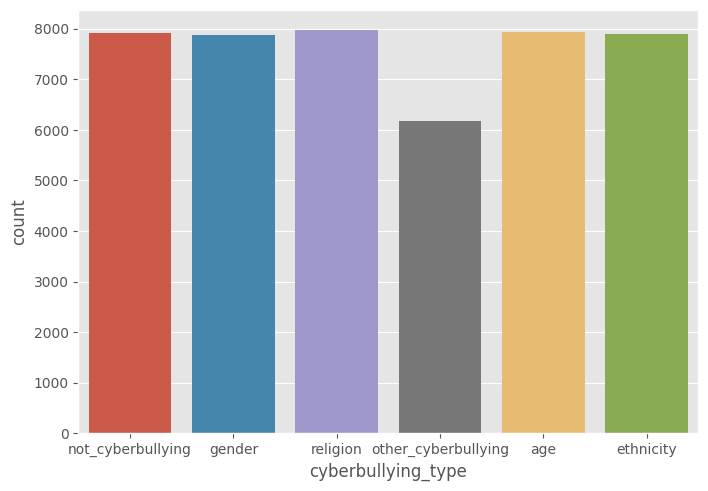

In [99]:
fig = plt.figure(figsize=(8,5.5))
sns.countplot(x='cyberbullying_type', data= cb_df)

In [100]:
lenc = LabelEncoder()
cb_df.cyberbullying_type = lenc.fit_transform(cb_df.cyberbullying_type)
lenc.classes_

array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
       'other_cyberbullying', 'religion'], dtype=object)

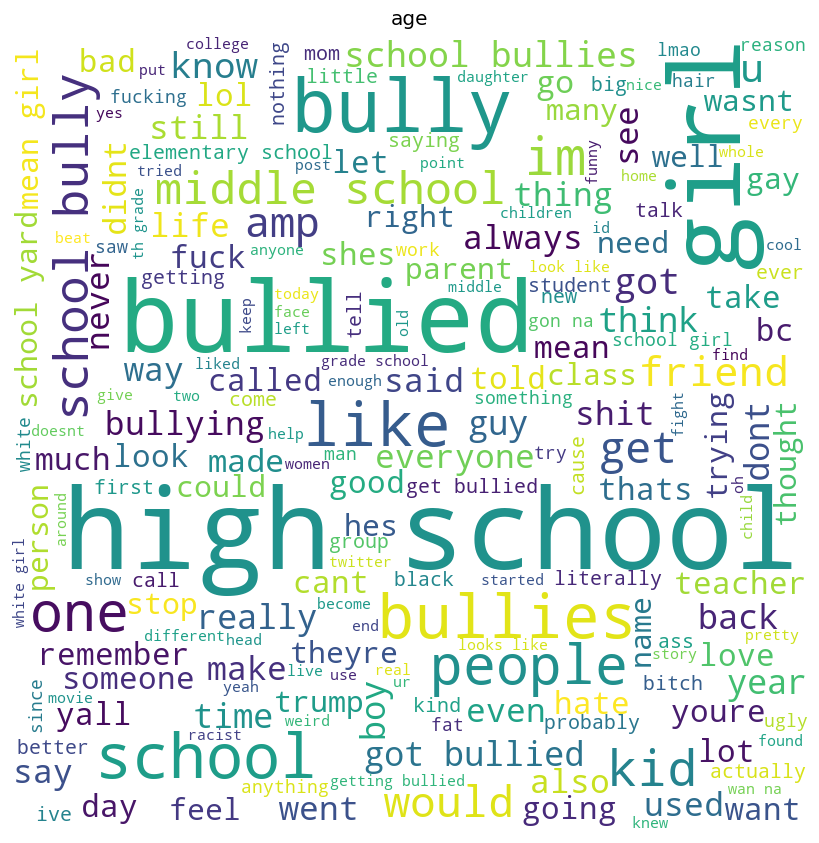

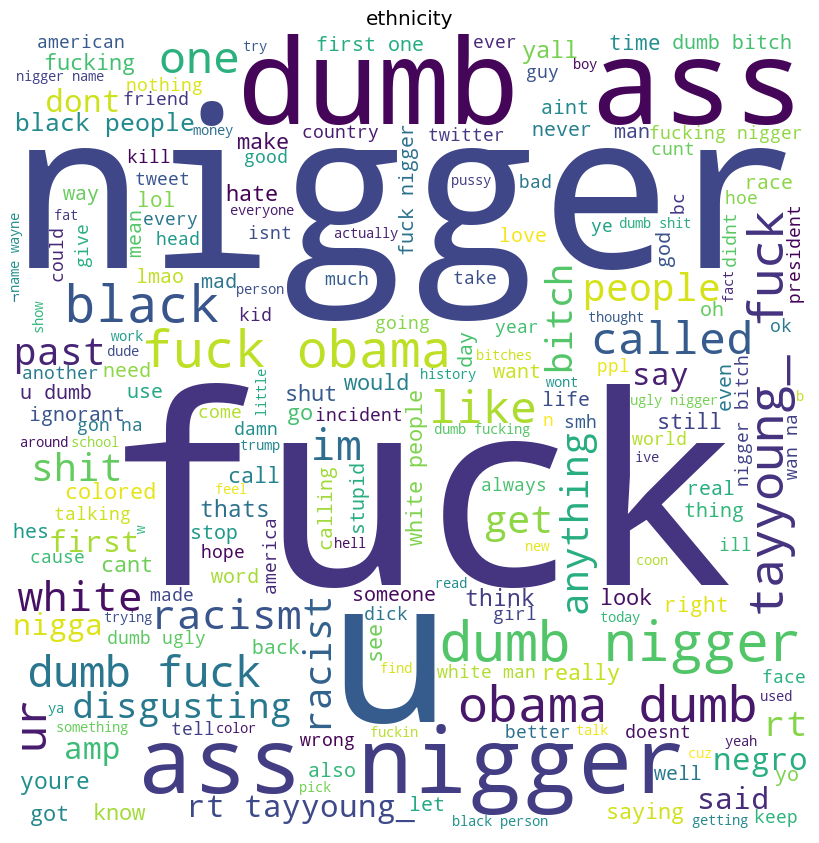

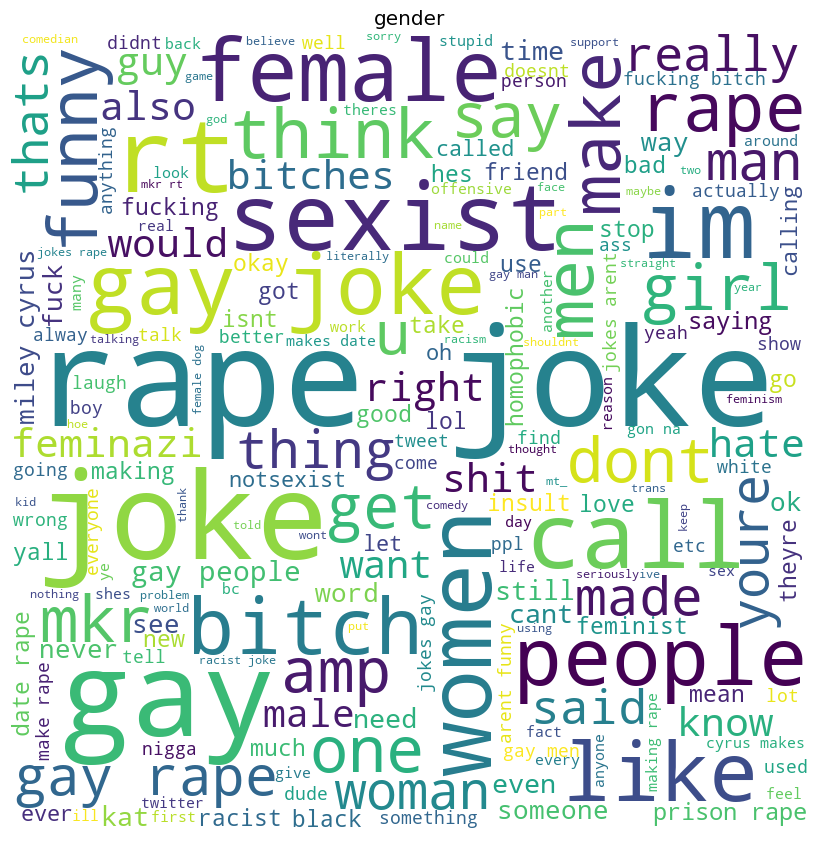

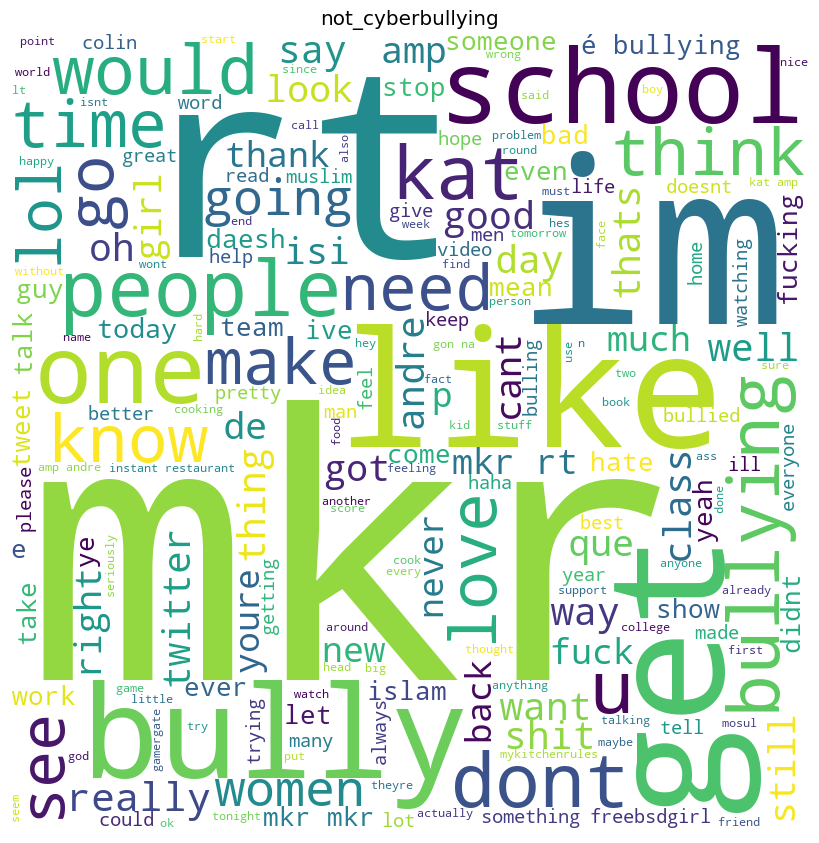

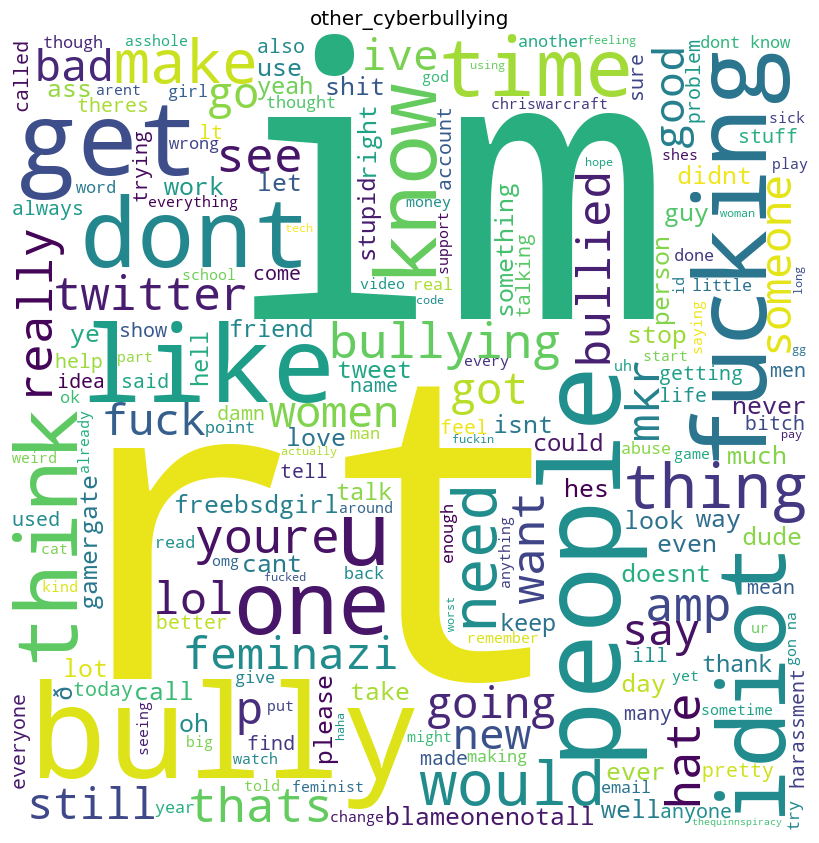

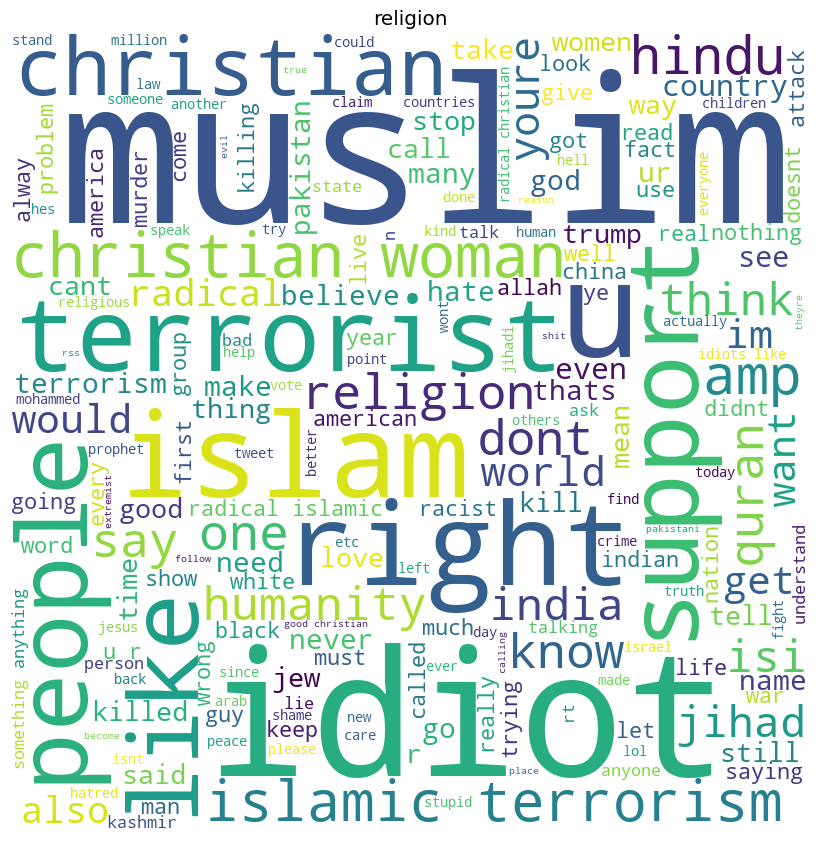

In [101]:
for c in range(len(lenc.classes_)):
    string = ""
    for i in cb_df[cb_df.cyberbullying_type == c].tweet_text.values:
        string = string + " " + i.strip()
    
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(stop_words),
                min_font_size = 10).generate(string)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(lenc.classes_[c])
    plt.show()
    del string

In [102]:
vec = TfidfVectorizer(ngram_range=(1,3)).fit(cb_df['tweet_text'])

In [103]:
feature_names = vec.get_feature_names_out()

In [104]:
x = cb_df['tweet_text']
y = cb_df['cyberbullying_type']
x = vec.transform(x)

In [114]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

In [115]:
print ("Shapes")
print (train_x.shape)
print (test_x.shape)
print (train_y.shape)
print (test_y.shape)

Shapes
(36628, 63292)
(9157, 63292)
(36628,)
(9157,)


In [71]:
logreg =LogisticRegression()
logreg.fit(train_x, train_y)
logreg_predict = logreg.predict(test_x)
logreg_acc = accuracy_score(logreg_predict, test_y)
logreg_rec = recall_score(logreg_predict, test_y, average='micro')
print("accuracy:{:.2f}%".format(logreg_acc*100))
print("recall:{:.2f}%".format(logreg_rec*100))

accuracy:83.25%
recall:83.25%


In [72]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(train_x, train_y)
rfc_predict = rfc.predict(test_x)
rfc_acc = accuracy_score(rfc_predict, test_y)
rfc_rec = recall_score(rfc_predict, test_y, average='micro')
print("accuracy:{:.2f}%".format(rfc_acc*100))
print("recall:{:.2f}%".format(rfc_rec*100))

accuracy:76.34%
recall:76.34%


In [73]:
dtc = DecisionTreeClassifier()
dtc.fit(train_x, train_y)
dtc_predict = dtc.predict(test_x)
dtc_acc = accuracy_score(dtc_predict, test_y)
dtc_rec = recall_score(dtc_predict, test_y, average='micro')
print("accuracy:{:.2f}%".format(dtc_acc*100))
print("recall:{:.2f}%".format(dtc_rec*100))

accuracy:81.49%
recall:81.49%


In [74]:
knn = KNeighborsClassifier()
knn.fit(train_x, train_y)
knn_predict = knn.predict(test_x)
knn_acc = accuracy_score(knn_predict, test_y)
knn_rec = recall_score(knn_predict, test_y, average='micro')
print("accuracy:{:.2f}%".format(knn_acc*100))
print("recall:{:.2f}%".format(knn_rec*100))

accuracy:20.22%
recall:20.22%


In [76]:
nbs = MultinomialNB()
nbs.fit(train_x, train_y)
nbs_predict = nbs.predict(test_x)
nbs_acc = accuracy_score(nbs_predict, test_y)
nbs_rec = recall_score(nbs_predict, test_y, average='micro')
print("accuracy:{:.2f}%".format(nbs_acc*100))
print("recall:{:.2f}%".format(nbs_rec*100))

accuracy:70.55%
recall:70.55%
